## Домашнее задание<a class='anchor' id='hw'>

Урок 6. Градиентный бустинг

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Функция предсказания в градиентном бустинге

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

Функционал ошибки MSE

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Берем со знаком "минус"

In [6]:
def residual(y, z):
    return - (z - y)

Функция обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [20]:
n_trees_list = np.linspace(10, 50, 9).astype('int')
n_trees_list

array([10, 15, 20, 25, 30, 35, 40, 45, 50])

In [21]:
max_depth_list = np.linspace(3, 9, 7).astype('int')
max_depth_list

array([3, 4, 5, 6, 7, 8, 9])

In [28]:
%%time
eta = 0.5
n_trees = 10
depth_train_errors = []
depth_test_errors = []

for max_depth in max_depth_list:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    depth_train_errors.append(train_errors[-1])
    depth_test_errors.append(test_errors[-1])

Wall time: 21.9 s


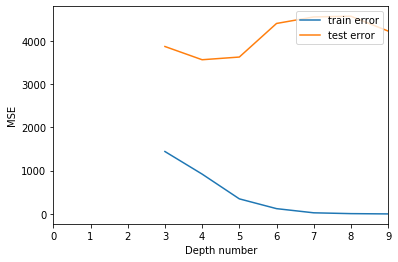

In [29]:
plt.xlabel('Depth number')
plt.ylabel('MSE')
plt.xlim(0, max_depth_list[-1])
plt.plot(list(max_depth_list), depth_train_errors, label='train error')
plt.plot(list(max_depth_list), depth_test_errors, label='test error')
plt.legend(loc='upper right')
plt.show()